In [437]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm
from scipy import stats

df_emotion_and_LIWC = pd.read_csv("LIWC_and_emotions.csv")

In [706]:
############### Making a balanced dataframe #################
'''random.seed(1)

df_emotion_and_LIWC = pd.read_csv("LIWC_and_emotions.csv")
pos = (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="Y"])
neg= (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="N"])
df_neg_only = neg.sample(n=len(pos), random_state =1)
#df_pos_only = pos.sample(n=1500, random_state =1)


df_emotion = pd.concat([df_neg_only, pos])'''




In [707]:
df_time_adj = pd.read_csv("LIWC2015 Results (previous_reviews.csv).csv")
df_time_adj.rename(columns={'K':'originalRevID','A': 'date', 'B': 'reviewID', 'C':'reviewerID', 'D': 'review', 'E': 'rating', 'F':'usefulCount', 'G':'coolCount','H':'funnyCount', 'I': 'flagged','J': 'restaurantID'}, inplace=True)
df_time_adj=df_time_adj.drop(0)

In [708]:
#df_temp = df_time_adj[["date", "reviewID","rating","Tone","Analytic","Clout","Authentic","WC"]]
df_temp = df_time_adj.drop(columns=["flagged","reviewerID","reviewID","restaurantID","review"])
df_temp.rename(columns={'originalRevID':'reviewID','anger':'anger_LIWC'}, inplace=True)

df_temp.rating = df_temp.rating.astype(float)
df_time_adjusted_features = df_temp.groupby("reviewID").mean().reset_index()

In [709]:
df_time_adjusted_features.rename(columns={'rating': 'priorRating',
                                          'Tone': 'priorTone', 
                                          'Clout':'priorClout',
                                          'Analytic':'priorAnalytic', 
                                          'Authentic': 'priorAuthentic',
                                          'WC': 'priorWC',
                                          'i':'priorI',
                                         'we':'priorWe',
                                         'you':'priorYou',
                                         'shehe':'priorShehe',
                                         'ipron':'priorIpron'}, inplace=True)


In [710]:
df_base = df_emotion
#[["rating","Tone","Analytic","Clout","Authentic","WC","flagged","reviewID", "anger",
                     # "disgust","fear","sadness","joy","i"]]

In [711]:
df_combined = pd.merge(df_time_adjusted_features,df_base, on="reviewID")

In [712]:
import sqlite3

def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connect_db("/Users/jamesfyfe/summer vac misc/yelpResData.db")
cur = conn.cursor()


res_ids = tuple(df_combined["restaurantID"].unique())
query = "SELECT restaurantID,rating FROM restaurant WHERE restaurantID in {}".format(res_ids)
cur.execute(query)
res_ratings = cur.fetchall()

In [713]:
df_res = pd.DataFrame(res_ratings, columns={"resRating","restaurantID"})
df_combined = pd.merge(df_combined,df_res, on="restaurantID")

In [714]:
df_combined["ratingDiff"] = np.abs(df_combined["rating"] - df_combined["priorRating"])
df_combined["AnalyticDiff"] = np.abs(df_combined["Analytic"] - df_combined["priorAnalytic"])
df_combined["ToneDiff"] = np.abs(df_combined["Tone"] - df_combined["priorTone"])
df_combined["CloutDiff"] = np.abs(df_combined["Clout"] - df_combined["priorClout"])
df_combined["AuthenticDiff"] = np.abs(df_combined["Authentic"] - df_combined["priorAuthentic"])
df_combined["WCDiff"] = np.abs(df_combined["WC"] - df_combined["priorWC"])
df_combined["IDiff"] = np.abs(df_combined["i"] - df_combined["priorI"])
df_combined["WeDiff"] = np.abs(df_combined["we"] - df_combined["priorWe"])
df_combined["YouDiff"] = np.abs(df_combined["you"] - df_combined["priorYou"])
df_combined["SheheDiff"] = np.abs(df_combined["shehe"] - df_combined["priorShehe"])
df_combined["IpronDiff"] = np.abs(df_combined["ipron"] - df_combined["priorIpron"])


df_combined["ratingDiffOriginal"] = np.abs(df_combined["rating"] - df_combined["resRating"])



df_combined=df_combined[[
                         "ratingDiff",
                         "rating",
                         "AnalyticDiff","ToneDiff",
                         "CloutDiff","AuthenticDiff","WCDiff",
                         "flagged",#"ratingDiffOriginal",
                        # 'IDiff','WeDiff',"YouDiff","SheheDiff","IpronDiff",
                         #"Tone",
                         "Analytic","Clout","Authentic",
                         "WC"
                        # "i","we","you","shehe","ipron"
                         #"anger","disgust","sadness","joy","fear","anx","anger_LIWC","posemo","sad"
                        ]]
                            
                        


#df_combined=df_combined.drop(columns="reviewID")

Optimization terminated successfully.
         Current function value: 0.637519
         Iterations 5

Train Accuracy: 0.6404020254718429

Test Accuracy: 0.6320957348880024
                           Logit Regression Results                           
Dep. Variable:                flagged   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13022
Method:                           MLE   Df Model:                           11
Date:                Fri, 29 Jan 2021   Pseudo R-squ.:                 0.08025
Time:                        15:19:20   Log-Likelihood:                -8309.4
converged:                       True   LL-Null:                       -9034.5
Covariance Type:            nonrobust   LLR p-value:                1.858e-304
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9909      0

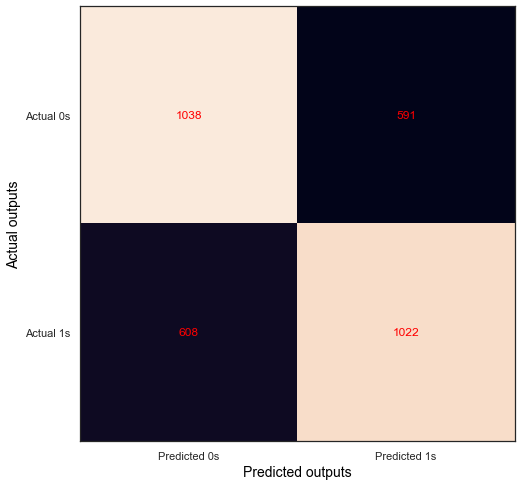

In [715]:
from sklearn.preprocessing import StandardScaler

def logit_regression(df_reg_emotion):
    le_emotion = preprocessing.LabelEncoder()
    df_reg_emotion["flagged"] = le_emotion.fit_transform(df_reg_emotion["flagged"])

    X = df_reg_emotion.drop(columns=["flagged"])
    X = sm.add_constant(X)
    Y = df_reg_emotion["flagged"]

    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)

    model = sm.Logit(Y_train, X_train)
    result = model.fit()
    
    print("\nTrain Accuracy: " + str(sum((result.predict(X_train) >= 0.5).astype(int) == Y_train)/len(Y_train)))
    print("\nTest Accuracy: " + str(sum((result.predict(X_test) >= 0.5).astype(int) == Y_test)/len(Y_test)))
    print(result.summary())
    print(classification_report(Y_test, (result.predict(X_test) >= 0.5).astype(int)))
    cm = confusion_matrix(Y_test, (result.predict(X_test) >= 0.5).astype(int))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', fontsize=14, color='black')
    ax.set_ylabel('Actual outputs', fontsize=14, color='black')
    ax.xaxis.set(ticks=(0,1),ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1),ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

logit_regression(df_combined)

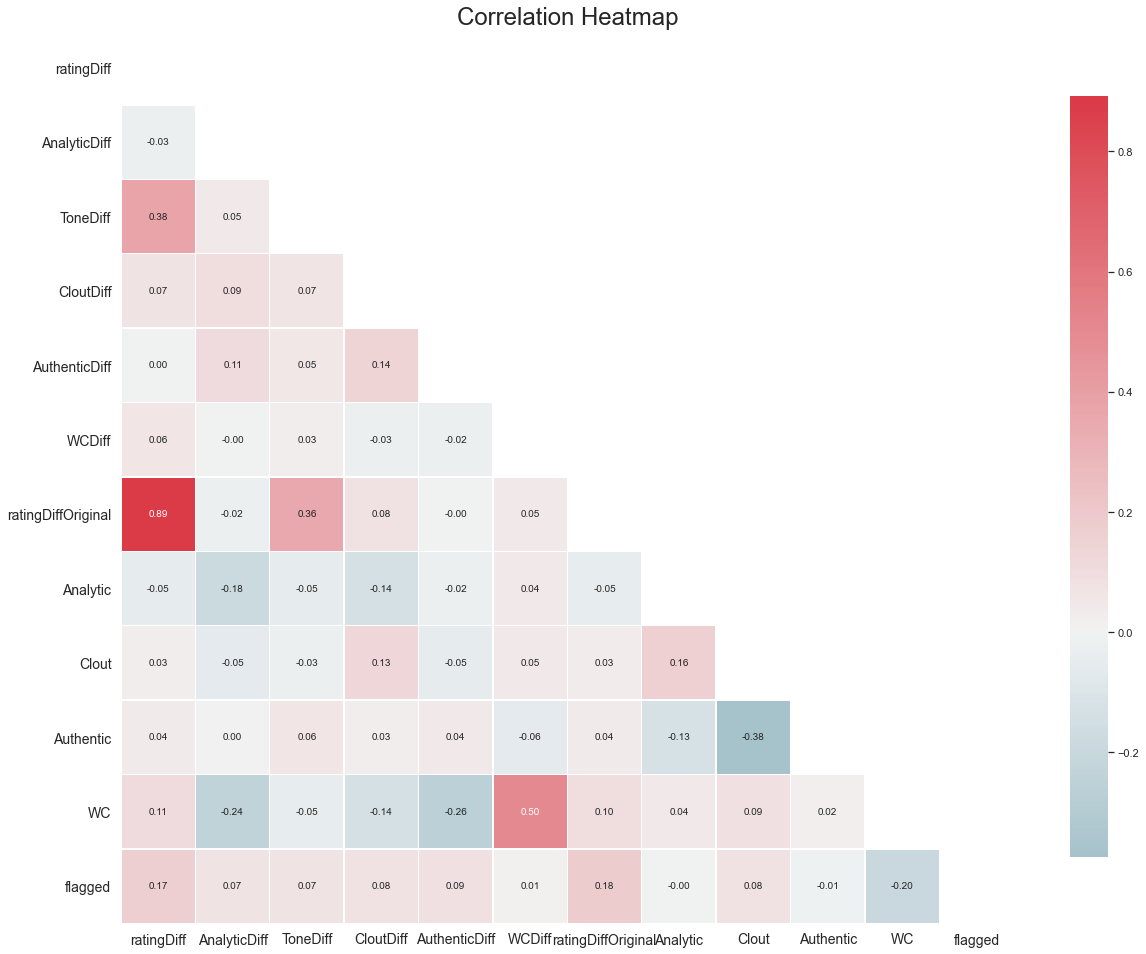

In [678]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df_fs):
    sns.set(style="white")
    # Calculating Pearson's correlation coefficient of the subsetted data
    correlation = (pd.concat([df_fs.drop(columns=["flagged"]),df_fs["flagged"]], axis=1)).corr()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation, center=0, mask=mask,cmap=cmap,
                fmt='.2f', square=True, linewidths=.5, 
                annot=True, cbar_kws={"shrink": .70},  
                annot_kws={"size": 10})
    ax.set_title('Correlation Heatmap', fontsize = 24)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

    
heatmap(df_combined)

In [519]:
############################# Comparison of features ###########################

In [ ]:
###################### A summary table of comparative statistics for fake and real reviews #####################
stats_lst = []
no_emotions_lst = []

feature_lst = [ # includes emotions
 'WC',
 'Analytic',
 'Tone',
 'Clout',
 'Authentic',
 'joy',
 'anger',
 'sadness',
 'disgust',
 'fear',
 'Readability',
 'Rating',
 'ResRating',
 'RatingExtremity',
 'RatingExtremityAdjusted',
 'NumReviews',
 #'RatingDiff',
# 'RatingDiffPrior',
 'ipron', #impersonal pronouns
    'i',
    'we',
    'you',
 'shehe',
 'they']

################ without emotions ##############
linguist_feature_lst = [ # the Top Reviewer paper features only
 'WC',
 'Analytic',
 'Tone',
 'Clout',
 'Authentic',
 'Readability',
 'Rating',
 'RatingDiff']


for feature in feature_lst:
    mean_real = np.mean(df_emotion[df_emotion["flagged"]=="N"][feature])
    mean_fake = np.mean(df_emotion[df_emotion["flagged"]=="Y"][feature])
    med_real = np.median(df_emotion[df_emotion["flagged"]=="N"][feature])
    med_fake = np.median(df_emotion[df_emotion["flagged"]=="Y"][feature])
    stdev_real = np.std(df_emotion[df_emotion["flagged"]=="N"][feature])
    stdev_fake = np.std(df_emotion[df_emotion["flagged"]=="Y"][feature])
    stats_lst.append([feature,"real",mean_real,med_real,stdev_real])
    stats_lst.append([feature,"fake",mean_fake,med_fake,stdev_fake])

In [ ]:
paired_stats = pd.DataFrame(stats_lst,columns=["Feature","Review","Mean","Median","Stdev"])

################ without emotions ##############
paired_stats_original_paper = paired_stats[paired_stats["Feature"].isin(linguist_feature_lst)]

In [464]:
df_emotion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16320 entries, 6050 to 16409
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          16320 non-null  object 
 1   reviewID      16320 non-null  object 
 2   reviewerID    16320 non-null  object 
 3   review        16320 non-null  object 
 4   rating        16320 non-null  int64  
 5   flagged       16320 non-null  object 
 6   restaurantID  16320 non-null  object 
 7   WC            16320 non-null  int64  
 8   Analytic      16320 non-null  float64
 9   Clout         16320 non-null  float64
 10  Authentic     16320 non-null  float64
 11  Tone          16320 non-null  float64
 12  WPS           16320 non-null  float64
 13  Sixltr        16320 non-null  float64
 14  pronoun       16320 non-null  float64
 15  ppron         16320 non-null  float64
 16  i             16320 non-null  float64
 17  we            16320 non-null  float64
 18  you           16320 non

In [716]:
plt.scatter(df_final["flagged"],df_final["WC"])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-716-00e191d7c2c4>", line 1, in <module>
    plt.scatter(df_final["flagged"],df_final["WC"])
NameError: name 'df_final' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_

TypeError: object of type 'NoneType' has no len()